In [143]:
!pip install numpy matplotlib wfdb ipywidgets tsaug --quiet

In [256]:
import os
import numpy as np
import wfdb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import resample
from sklearn.metrics import f1_score

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Labeling

In [263]:
# Define the directory where the data is stored
data_directory = '/content/drive/MyDrive/ctu-chb-intrapartum-cardiotocography-database-1.0.0'

# List all .dat files in the directory
dat_files = [f for f in os.listdir(data_directory) if f.endswith('.dat')]

parameter_thresholds = {
    "pH": (7.15,999),
    "Apgar5": (7.0, 9.0),
}

Record Information:
Signals: ['FHR', 'UC']
Units: ['bpm', 'nd']


<ipython-input-264-be19b267f818>:30: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-ticks')


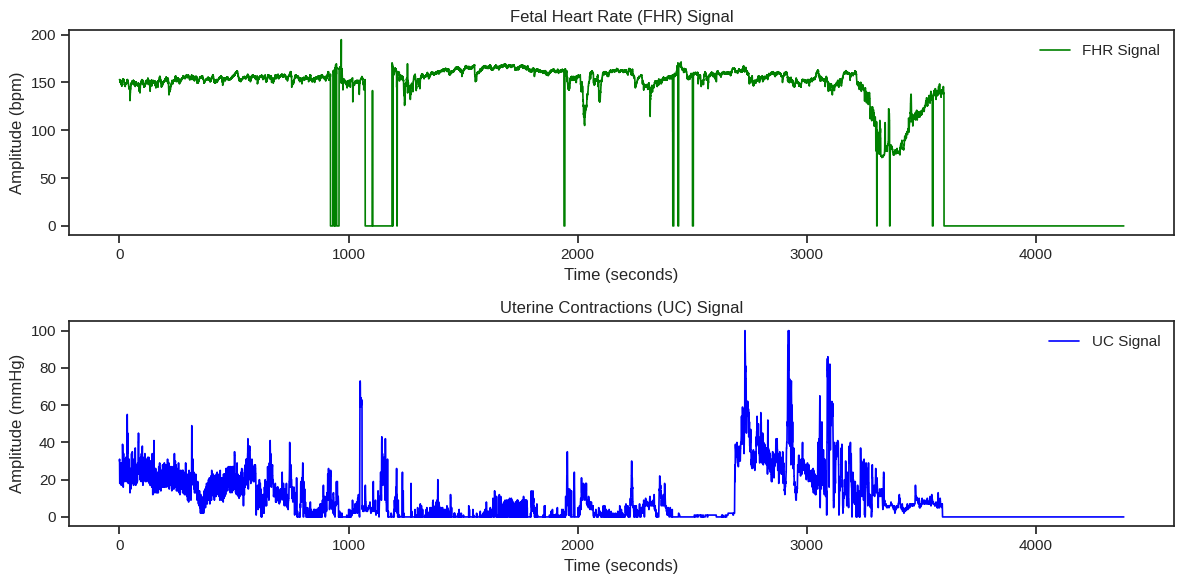

In [264]:
#Visualizing a sample (most distressed case)
import wfdb
import matplotlib.pyplot as plt
import os
import numpy as np

# Specify the record name
record_name = "2023"  # Replace with the desired record name

# Load the record
record = wfdb.rdrecord(os.path.join(data_directory, record_name))

# Extract FHR and UC signals
fhr_signal = record.p_signal[:, record.sig_name.index('FHR')]
uc_signal = record.p_signal[:, record.sig_name.index('UC')]

# Print information about the record
print("Record Information:")
print("Signals:", record.sig_name)
print("Units:", record.units)

# Get the metadata to obtain the correct units
fhr_units = record.units[record.sig_name.index('FHR')]
uc_units = record.units[record.sig_name.index('UC')]

# Calculate the time vector based on the sampling frequency
time_vector = (1 / record.fs) * np.arange(len(fhr_signal))

# Set up a clean and professional plot with a professional color scheme
plt.style.use('seaborn-ticks')
plt.figure(figsize=(12, 6))

# Plot FHR signal
plt.subplot(2, 1, 1)
plt.plot(time_vector, fhr_signal, color='green', label='FHR Signal', linewidth=1.2)
plt.title('Fetal Heart Rate (FHR) Signal')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude ({})'.format(fhr_units))
plt.legend()

# Plot UC signal
plt.subplot(2, 1, 2)
plt.plot(time_vector, uc_signal, color='blue', label='UC Signal', linewidth=1.2)
plt.title('Uterine Contractions (UC) Signal')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude (mmHg)')
plt.legend()

# Fine-tune layout for a professional look
plt.tight_layout()

# Display the plot
plt.show()


In [265]:
# Initialize lists to corresponding labels
labels = []

# Process the uploaded .dat files and assign labels based on parameter thresholds
for dat_file in dat_files:
    record_name = os.path.splitext(dat_file)[0]  # Remove the .dat extension
    record = wfdb.rdrecord(os.path.join(data_directory, record_name))

    # Load the corresponding .hea file to access header information
    hea_file_path = os.path.join(data_directory, record_name + '.hea')
    with open(hea_file_path, 'r') as hea_file:
        hea_content = hea_file.read()

    # Check distress criteria based on thresholds
    distress_flag = False
    for param, (low, high) in parameter_thresholds.items():
        param_value = float(hea_content.split(f"#{param}")[-1].split()[0])
        if param_value < low:
          distress_flag = True
          break


    # Assign labels based on distress flag
    label = "Distress" if distress_flag else "Normal"
    labels.append(label)

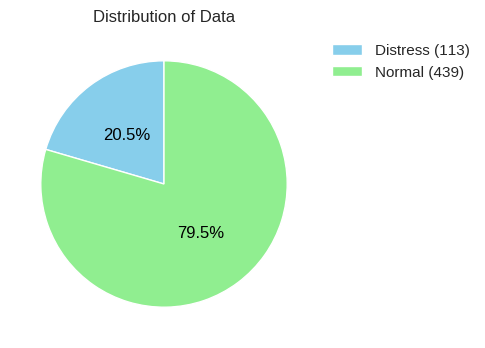

In [266]:
import matplotlib.pyplot as plt

# Convert binary labels to original format ("Normal" and "Distress")
original_labels = np.array(labels)

# Calculate label distribution
unique_labels, label_counts = np.unique(original_labels, return_counts=True)

# Define colors for each class
class_colors = ['skyblue', 'lightgreen']

# Plot pie chart with labels outside and values inside
plt.figure(figsize=(4, 4))
wedges, texts, autotexts = plt.pie(label_counts, labels=None, autopct='%1.1f%%', startangle=90,
                                  textprops={'color': "black"}, pctdistance=0.5, labeldistance=1.1, colors=class_colors)

# Add labels outside the pie chart
plt.legend(wedges, [f'{label} ({count})' for label, count in zip(unique_labels, label_counts)],
           loc='upper left', bbox_to_anchor=(1.0, 1.0))

plt.title('Distribution of Data')
plt.show()


In [267]:
import os
import numpy as np
import wfdb
from scipy.signal import resample

# Initialize variables to store maximum values
max_fhr_bpm = 0
max_uc_value = 0

for dat_file in dat_files:
    record_name = os.path.splitext(dat_file)[0]  # Remove the .dat extension
    record = wfdb.rdrecord(os.path.join(data_directory, record_name))

    # Extract FHR and UC signals
    fhr_signal = record.p_signal[:, record.sig_name.index('FHR')]
    uc_signal = record.p_signal[:, record.sig_name.index('UC')]

    # Find maximum FHR BPM and UC value in the current record
    max_fhr_bpm = max(max_fhr_bpm, np.max(fhr_signal))
    max_uc_value = max(max_uc_value, np.max(uc_signal))

# Initialize an empty list to store preprocessed signals
X_signals = []

for dat_file in dat_files:
    record_name = os.path.splitext(dat_file)[0]  # Remove the .dat extension
    record = wfdb.rdrecord(os.path.join(data_directory, record_name))

    # Extract FHR and UC signals
    fhr_signal = record.p_signal[:, record.sig_name.index('FHR')]
    uc_signal = record.p_signal[:, record.sig_name.index('UC')]

    # Resample signals to a common length
    common_length = 1000
    fhr_signal_resampled = resample(fhr_signal, common_length)
    uc_signal_resampled = resample(uc_signal, common_length)

    # Normalize FHR signal
    fhr_signal_resampled /= max_fhr_bpm

    # Normalize UC signal
    uc_signal_resampled /= max_uc_value

    # Combine FHR and UC signals into a single feature vector
    combined_signal = np.concatenate((fhr_signal_resampled, uc_signal_resampled))

    # Append the preprocessed signal to the list
    X_signals.append(combined_signal)

# Convert the list to a NumPy array for further processing
X_signals = np.array(X_signals)

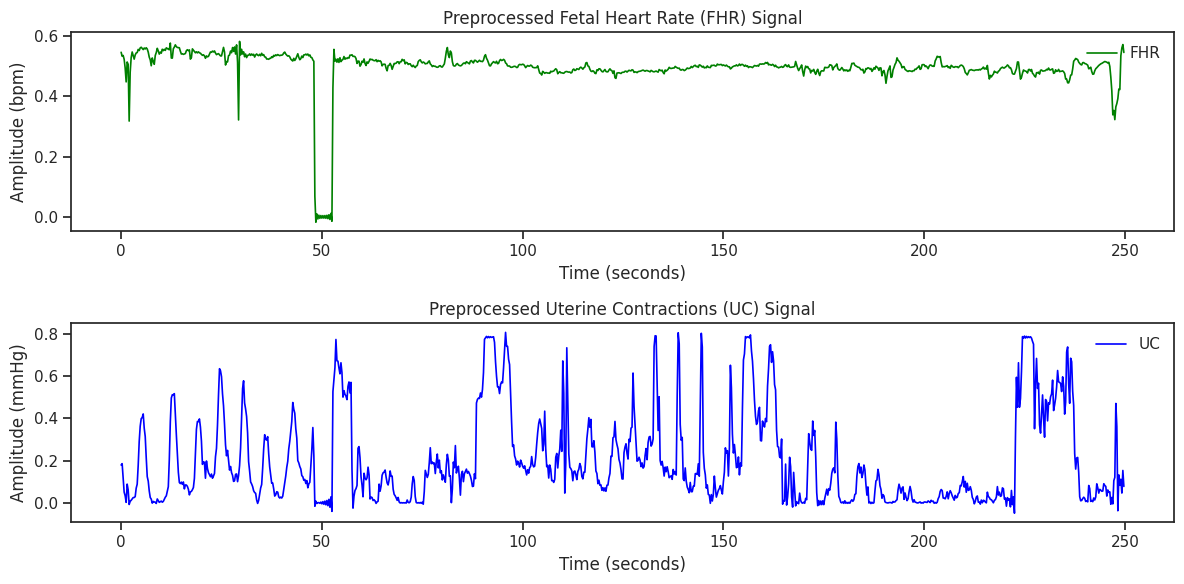

In [268]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the time vector based on the sampling frequency
time_vector = (1 / record.fs) * np.arange(common_length)

# Plotting
sns.set(style="ticks")
plt.figure(figsize=(12, 6))

# Plot the preprocessed FHR signal
plt.subplot(2, 1, 1)
plt.plot(time_vector, fhr_signal_resampled, color='green', label='FHR', linewidth=1.2)
plt.title('Preprocessed Fetal Heart Rate (FHR) Signal')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude ({})'.format(fhr_units))
plt.legend(loc='upper right')

# Plot UC signal
plt.subplot(2, 1, 2)
plt.plot(time_vector, uc_signal_resampled, color='blue', label='UC', linewidth=1.2)
plt.title('Preprocessed Uterine Contractions (UC) Signal')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude (mmHg)')
plt.legend(loc='upper right')

# Fine-tune layout for a professional look
plt.tight_layout()

# Display the plot
plt.show()


In [269]:
print(max_fhr_bpm,max_uc_value)

293.0 127.5


In [270]:
# Convert features and labels lists to NumPy arrays
X_signals = np.array(X_signals)
labels = np.array(labels)

In [271]:
X_signals.shape

(552, 2000)

In [272]:
labels.shape

(552,)

In [273]:
import numpy as np

# Define the data augmentation parameters
std_dev = 0.01  # Adjust this value based on your preference

# Increase the number of augmentations per sample to achieve a larger dataset
num_augmentations_per_sample = 20  # Adjust this number as needed

# Apply data augmentation to each sample in X_signals
augmented_X_signals = []
augmented_labels = []

for i in range(X_signals.shape[0]):
    original_signal = X_signals[i, :]

    # Apply augmentation to the original signal multiple times
    for _ in range(num_augmentations_per_sample):
        # Generate Gaussian noise
        noise = np.random.normal(0, std_dev, original_signal.shape)

        # Add noise to the original signal
        augmented_signal = original_signal + noise

        augmented_X_signals.append(augmented_signal)
        augmented_labels.append(labels[i])

# Reshape augmented data to match the original data shape
augmented_X_signals_reshaped = np.array(augmented_X_signals).reshape(-1, X_signals.shape[1])

# Concatenate original and augmented data
X_signals_augmented = np.vstack((X_signals, augmented_X_signals_reshaped))
labels_augmented = np.concatenate((labels, augmented_labels))

# Shuffle the augmented dataset
shuffle_indices = np.random.permutation(X_signals_augmented.shape[0])
X_signals_augmented = X_signals_augmented[shuffle_indices]
labels_augmented = labels_augmented[shuffle_indices]


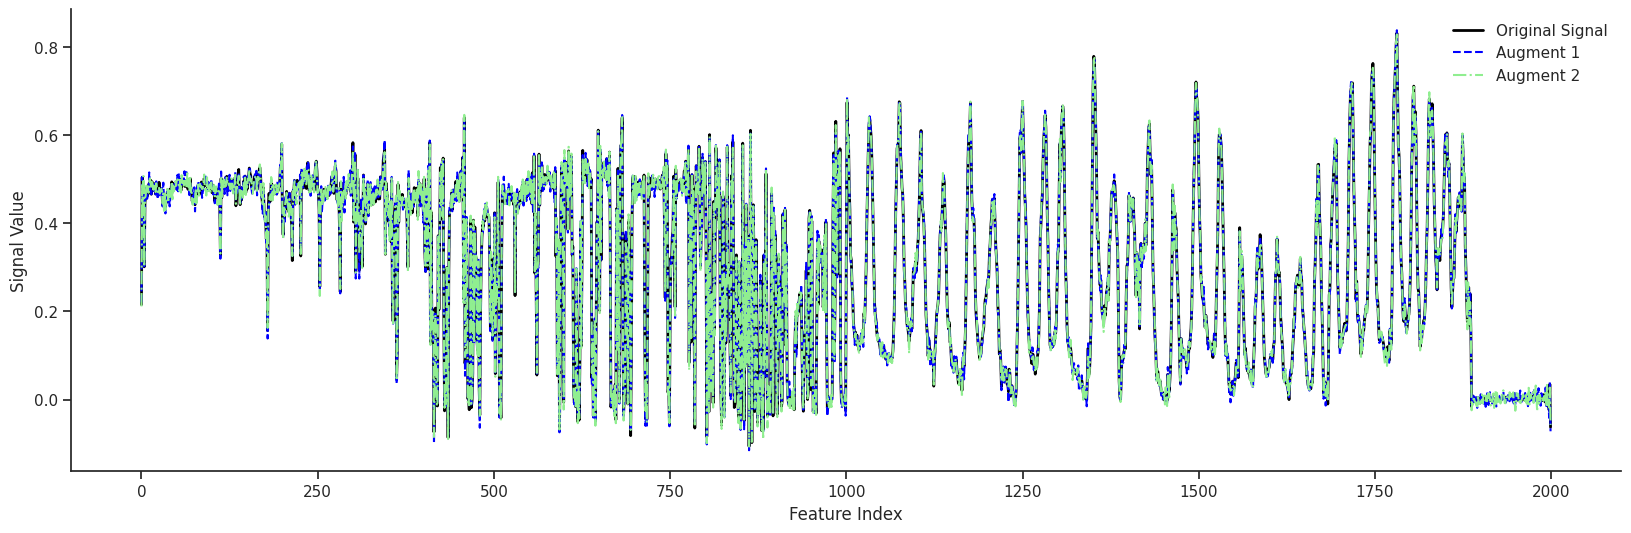

In [274]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Select a specific sample index (wrap around if out of bounds)
sample_index = 2018 % X_signals.shape[0]

original_sample = X_signals[sample_index, :]
augmented_samples = augmented_X_signals_reshaped[
    sample_index * num_augmentations_per_sample : (sample_index + 1) * num_augmentations_per_sample, :
]

# Calculate Euclidean distances between original and augmented signals
correlations = [pearsonr(original_sample, augmented_samples[i, :]) for i in range(num_augmentations_per_sample)]

# Select the indices of the most distinct signals (e.g., top 3)
most_distinct_indices = sorted(range(num_augmentations_per_sample), key=lambda i: correlations[i], reverse=True)[:2]

# Set Seaborn style
sns.set(style="ticks")

# Plot the original and the most distinct augmented signals with different line styles and colors
plt.figure(figsize=(20, 6))

# Plot original signal
plt.plot(original_sample, label='Original Signal', linewidth=2, color='black')

# Different line styles and colors for augmented signals
line_styles = ['--', '-.']
colors = ['blue', 'lightgreen']

for i, idx in enumerate(most_distinct_indices):
    plt.plot(augmented_samples[idx, :], label=f'Augment {i + 1}', linestyle=line_styles[i], color=colors[i], alpha=1)

plt.xlabel('Feature Index')
plt.ylabel('Signal Value')
plt.legend()

# Use Seaborn to enhance the plot
sns.despine()
plt.show()

In [275]:
X_signals_augmented.shape

(11592, 2000)

In [276]:
labels_augmented.shape

(11592,)

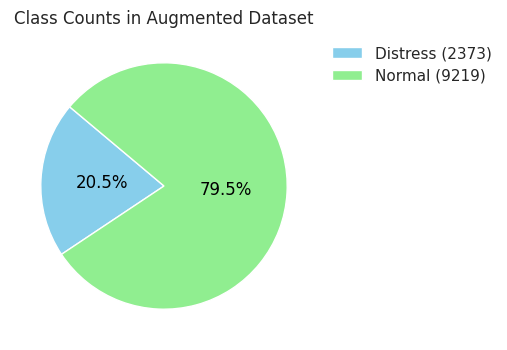

In [277]:
import matplotlib.pyplot as plt

# Calculate class counts
unique_labels, label_counts = np.unique(labels_augmented, return_counts=True)

# Total number of samples in the augmented dataset
total_samples = len(labels_augmented)

# Define colors for each class
class_colors = ['skyblue', 'lightgreen']  # Add more colors if needed

# Plot pie chart with labels outside and values inside
plt.figure(figsize=(4, 4))
plt.pie(label_counts, labels=None, autopct='%1.1f%%', startangle=140, textprops={'color': "black"},
        pctdistance=0.5, labeldistance=1.1, colors=class_colors)

# Add labels outside the pie chart
plt.legend(labels=[f'{label} ({count})' for label, count in zip(unique_labels, label_counts)],
           loc='upper left', bbox_to_anchor=(1.0, 1.0))

plt.title('Class Counts in Augmented Dataset')
plt.show()


In [278]:
from sklearn.model_selection import train_test_split

# Assuming you have a DataFrame, adjust accordingly if using a different data structure
import pandas as pd

# Create a DataFrame for easy manipulation
data = pd.DataFrame(data=X_signals_augmented)
data['labels'] = labels_augmented

# Separate distress and normal samples
distress_data = data[data['labels'] == 'Distress']
normal_data = data[data['labels'] == 'Normal']

# Sample random normal samples
balanced_normal_data = normal_data.sample(n=len(distress_data), random_state=42)

# Concatenate distress and balanced normal samples
balanced_data = pd.concat([distress_data, balanced_normal_data])

# Shuffle the balanced dataset
balanced_data = balanced_data.sample(frac=1, random_state=42)

# Split the balanced dataset into features and labels
X_balanced = balanced_data.drop(columns=['labels']).values
labels_balanced = balanced_data['labels'].values

# Split the balanced dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_balanced, labels_balanced, test_size=0.3, random_state=42)

In [279]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (3322, 2000)
X_test shape: (1424, 2000)


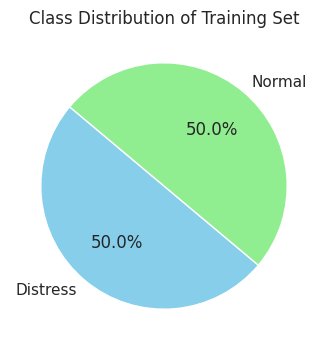

In [280]:
import matplotlib.pyplot as plt

# Assuming labels_train contains the class labels for your training set
# You can replace labels_train with labels_test for the test set
labels_train_unique, counts_train = np.unique(labels_balanced, return_counts=True)

class_colors=['skyblue','lightgreen']

# Create a pie chart
plt.figure(figsize=(4,4))
plt.pie(counts_train, labels=labels_train_unique, autopct='%1.1f%%', startangle=140,colors=class_colors)

plt.title('Class Distribution of Training Set')
plt.show()

In [281]:
# Encode labels to numerical values
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)


# SVM

In [290]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
y = np.array(labels)

# Reshape the data for SVM input
X_train_svm = X_train.reshape(X_train.shape[0], -1)
X_test_svm = X_test.reshape(X_test.shape[0], -1)

In [291]:
# Standardize the data
scaler = StandardScaler()
X_train_svm_std = scaler.fit_transform(X_train_svm)
X_test_svm_std = scaler.transform(X_test_svm)

In [292]:
# Initialize and train the SVM classifier
svm_clf = SVC(kernel='linear')

svm_clf.fit(X_train_svm_std, y_train_encoded)

SVC(kernel='linear')

In [293]:
# Evaluate the model
y_pred = svm_clf.predict(X_test_svm_std)

In [294]:
# Assuming 'le' is your LabelEncoder
y_test_decoded = le.inverse_transform(y_test_encoded)
y_pred_decoded = le.inverse_transform(y_pred.reshape(-1))

In [295]:
# Predictions
y_pred_svm = svm_clf.predict(X_test_svm_std)

In [296]:
# Evaluate the SVM model
from sklearn.metrics import precision_score, recall_score, f1_score

# Evaluate the SVM model
accuracy_svm = accuracy_score(y_test_decoded, y_pred_decoded)
precision_svm = precision_score(y_test_decoded, y_pred_decoded, average='weighted')
recall_svm = recall_score(y_test_decoded, y_pred_decoded, average='weighted')
f1_score_svm = f1_score(y_test_decoded, y_pred_decoded, average='weighted')

print("SVM Accuracy:", accuracy_svm)
print("SVM Precision:", precision_svm)
print("SVM Recall:", recall_svm)
print("SVM F1 Score:", f1_score_svm)


SVM Accuracy: 0.9943820224719101
SVM Precision: 0.9944443578675062
SVM Recall: 0.9943820224719101
SVM F1 Score: 0.9943818008200277


Classification Report:
              precision    recall  f1-score   support

    Distress       0.99      1.00      0.99       713
      Normal       1.00      0.99      0.99       711

    accuracy                           0.99      1424
   macro avg       0.99      0.99      0.99      1424
weighted avg       0.99      0.99      0.99      1424



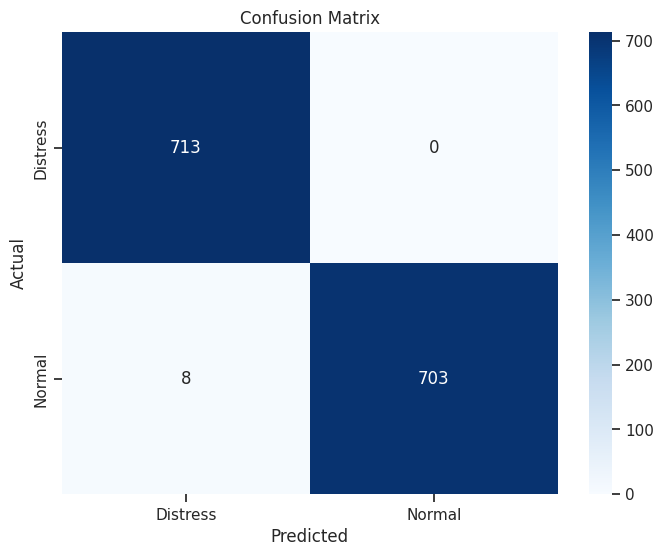

In [297]:
# Print the classification report and confusion matrix
print("Classification Report:")
print(classification_report(y_test_decoded, y_pred_decoded))

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test_decoded, y_pred_decoded)

# Visualize the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# CNN

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from keras import layers, models, Model
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import resample
from keras.optimizers import Adam
from sklearn.metrics import f1_score
from ipywidgets import interact, widgets
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Input, Conv1D, BatchNormalization, Activation, Add, GlobalAveragePooling1D, Dense, MaxPooling1D, Dropout
from keras.optimizers import Adam

In [24]:
# Reshape the data for CNN input
X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [25]:
#MODEL 1
learning_rate = 0.00011
batch_size = 64
from keras.regularizers import l2

model = Sequential()
model.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=(X_train_cnn.shape[1], X_train_cnn.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Conv1D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(0.6))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.8))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate), metrics=['accuracy'])


In [26]:
import pandas as pd

# Create an empty DataFrame with specified column names
table = pd.DataFrame(columns=["Name", "Type", "Shape"])


# Iterate through the layers in the model and append information to the DataFrame
for layer in model.layers:
    table = pd.concat([table, pd.DataFrame({
        "Name": [layer.name],
        "Type": [layer.__class__.__name__],
        "Shape": [layer.output_shape]
    })], ignore_index=True)

table


,Name,Type,Shape
0,conv1d,Conv1D,"(None, 1998, 32)"
1,max_pooling1d,MaxPooling1D,"(None, 999, 32)"
2,batch_normalization,BatchNormalization,"(None, 999, 32)"
3,dropout,Dropout,"(None, 999, 32)"
4,conv1d_1,Conv1D,"(None, 997, 64)"
5,max_pooling1d_1,MaxPooling1D,"(None, 498, 64)"
6,batch_normalization_1,BatchNormalization,"(None, 498, 64)"
7,dropout_1,Dropout,"(None, 498, 64)"
8,flatten,Flatten,"(None, 31872)"
9,dense,Dense,"(None, 128)"


In [27]:
# Train the model
history = model.fit(X_train_cnn, y_train_encoded, epochs=50, batch_size=batch_size, validation_data=(X_test_cnn, y_test_encoded))

Epoch 1/50
52/52 [==============================] - 10s 31ms/step - loss: 3.7189 - accuracy: 0.5608 - val_loss: 3.1795 - val_accuracy: 0.4993
Epoch 2/50
52/52 [==============================] - 1s 16ms/step - loss: 3.1675 - accuracy: 0.6144 - val_loss: 3.1214 - val_accuracy: 0.4993
Epoch 3/50
52/52 [==============================] - 1s 16ms/step - loss: 3.0147 - accuracy: 0.6478 - val_loss: 3.0641 - val_accuracy: 0.4993
Epoch 4/50
52/52 [==============================] - 1s 16ms/step - loss: 2.8874 - accuracy: 0.7008 - val_loss: 3.0224 - val_accuracy: 0.4993
Epoch 5/50
52/52 [==============================] - 1s 17ms/step - loss: 2.7716 - accuracy: 0.7194 - val_loss: 2.9147 - val_accuracy: 0.4993
Epoch 6/50
52/52 [==============================] - 1s 17ms/step - loss: 2.6842 - accuracy: 0.7411 - val_loss: 2.8233 - val_accuracy: 0.5246
Epoch 7/50
52/52 [==============================] - 1s 16ms/step - loss: 2.5632 - accuracy: 0.7703 - val_loss: 2.7549 - val_accuracy: 0.5253
Epoch 8/50
5

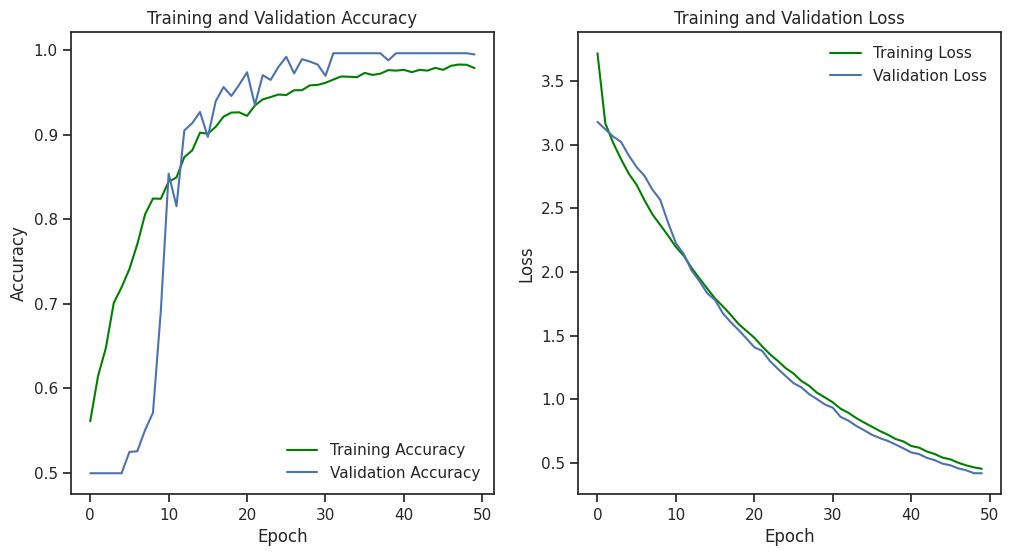

In [301]:
# Plot training history for accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'],color='green',label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')


# Plot training history for loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'],color='green', label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')


plt.show()

In [29]:
# Evaluate the model
y_pred_prob = model.predict(X_test_cnn)
y_pred = (y_pred_prob > 0.5).astype(int)

# Assuming 'le' is your LabelEncoder
y_test_decoded = le.inverse_transform(y_test_encoded)
y_pred_decoded = le.inverse_transform(y_pred.reshape(-1))

45/45 [==============================] - 0s 2ms/step


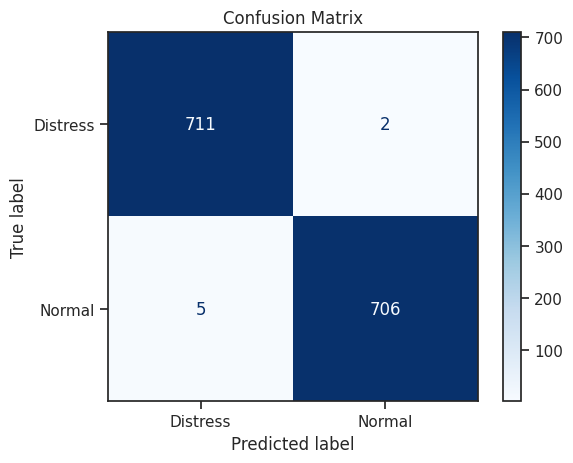

In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Confusion Matrix
conf_mat = confusion_matrix(y_test_decoded, y_pred_decoded)

# Plot Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=le.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()


In [31]:
# Classification Report
class_report = classification_report(y_test_decoded, y_pred_decoded)
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

    Distress       0.99      1.00      1.00       713
      Normal       1.00      0.99      1.00       711

    accuracy                           1.00      1424
   macro avg       1.00      1.00      1.00      1424
weighted avg       1.00      1.00      1.00      1424



In [32]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate True Positives, False Negatives, True Negatives, False Positives
TP = conf_mat[1, 1]
FN = conf_mat[1, 0]
TN = conf_mat[0, 0]
FP = conf_mat[0, 1]

# Calculate Accuracy, Precision, Recall, and F1 Score
accuracy_cnn = (TP + TN) / (TP + FN + TN + FP)
precision_cnn = TP / (TP+FP)
recall_cnn = TP / (TP+FN)
f1_score_cnn =  2*(recall_cnn * precision_cnn) / (recall_cnn + precision_cnn)

# Print Metrics
print("CNN Accuracy:", accuracy_cnn)
print("CNN Precision:", precision_cnn)
print("CNN Recall:", recall_cnn)
print("CNN F1 Score:", f1_score_cnn)


CNN Accuracy: 0.9950842696629213
CNN Precision: 0.9971751412429378
CNN Recall: 0.9929676511954993
CNN F1 Score: 0.9950669485553206


# Random Forest Classifier

In [107]:
from sklearn.ensemble import RandomForestClassifier as rfc

In [108]:
# Reshape the data for SVM input
X_train_rfc = X_train.reshape(X_train.shape[0], -1)
X_test_rfc = X_test.reshape(X_test.shape[0], -1)

In [109]:
rf_clf = rfc(n_estimators=50, max_depth=5, random_state=42)  # Adjust the maximum depth of the trees

rf_clf.fit(X_train_rfc, y_train_encoded)

RandomForestClassifier(max_depth=5, n_estimators=50, random_state=42)

In [110]:
y_pred=rf_clf.predict(X_test_rfc)

In [111]:
# Assuming 'le' is your LabelEncoder
y_test_decoded = le.inverse_transform(y_test_encoded)
y_pred_decoded = le.inverse_transform(y_pred.reshape(-1))

In [112]:
y_pred_rfc=rf_clf.predict(X_test_rfc)

In [113]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Evaluate the SVM model
accuracy_rfc = accuracy_score(y_test_decoded, y_pred_decoded)
precision_rfc = precision_score(y_test_decoded, y_pred_decoded, average='weighted')
recall_rfc = recall_score(y_test_decoded, y_pred_decoded, average='weighted')
f1_score_rfc = f1_score(y_test_decoded, y_pred_decoded, average='weighted')

print("RFC Accuracy:", accuracy_rfc)
print("RFC Precision:", precision_rfc)
print("RFC Recall:", recall_rfc)
print("RFC F1 Score:", f1_score_rfc)

RFC Accuracy: 0.9648876404494382
RFC Precision: 0.9658264892268835
RFC Recall: 0.9648876404494382
RFC F1 Score: 0.9648687902223652


Classification Report:
              precision    recall  f1-score   support

    Distress       0.94      0.99      0.97       713
      Normal       0.99      0.94      0.96       711

    accuracy                           0.96      1424
   macro avg       0.97      0.96      0.96      1424
weighted avg       0.97      0.96      0.96      1424



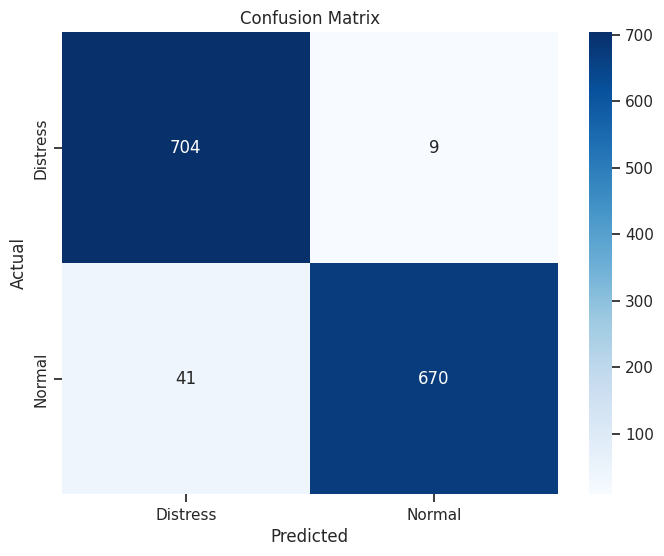

In [114]:
# Print the classification report and confusion matrix
print("Classification Report:")
print(classification_report(y_test_decoded, y_pred_decoded))

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test_decoded, y_pred_decoded)

# Visualize the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Accuracy Comparision

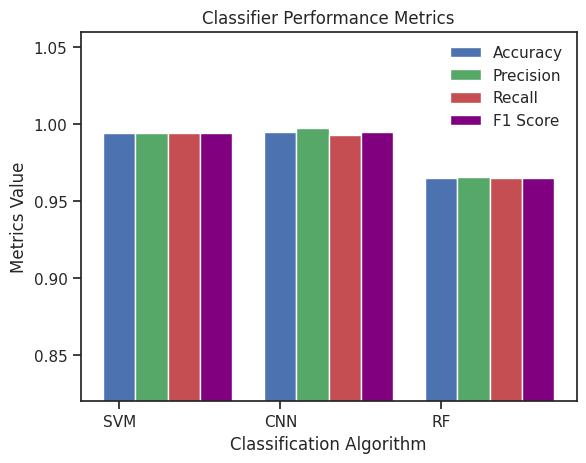

In [298]:
# Convert the bar_width to a numeric value
bar_width = 0.2  # or any other appropriate width
algorithms = ["SVM", "CNN", "RF"]
accuracy_values = [float(accuracy_svm), float(accuracy_cnn), float(accuracy_rfc)]
precision_values = [float(precision_svm), float(precision_cnn), float(precision_rfc)]
recall_values = [float(recall_svm), float(recall_cnn), float(recall_rfc)]
f1_score_values = [float(f1_score_svm), float(f1_score_cnn), float(f1_score_rfc)]

# Plot the metrics using grouped bar charts
plt.bar(algorithms, accuracy_values, color='b', width=bar_width, label='Accuracy')
plt.bar([a + bar_width for a in range(len(algorithms))], precision_values, color='g', width=bar_width, label='Precision')
plt.bar([a + 2 * bar_width for a in range(len(algorithms))], recall_values, color='r', width=bar_width, label='Recall')
plt.bar([a + 3 * bar_width for a in range(len(algorithms))], f1_score_values, color='purple', width=bar_width, label='F1 Score')

# Add labels and title
plt.xlabel("Classification Algorithm")
plt.ylabel("Metrics Value")
plt.title("Classifier Performance Metrics")

# Set y-axis range
plt.ylim(0.82, 1.06)

# Add legend
plt.legend()

# Show the plot
plt.show()


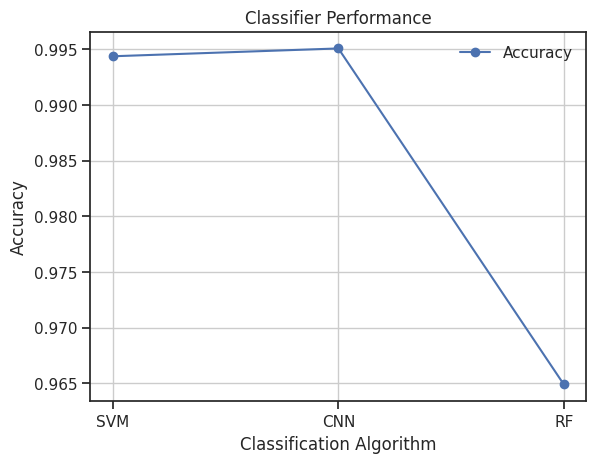

In [299]:
import matplotlib.pyplot as plt

# Create lists for algorithm names and accuracies
algorithms = ["SVM", "CNN", "RF"]
accuracies = [accuracy_svm, accuracy_cnn, accuracy_rfc]

# Plot the accuracies using a line chart
plt.plot(algorithms, accuracies, marker='o', linestyle='-', color='b', label='Accuracy')

# Add labels and title
plt.xlabel("Classification Algorithm")
plt.ylabel("Accuracy")
plt.title("Classifier Performance")

# Add legend
plt.legend()

# Show the plot
plt.grid(True)
plt.show()
